# BalancedRandomForestClassifier

In [1]:
import pandas as pd
train = pd.read_csv('../../../dataset/german_credit_train.csv')
train.head()

,Unnamed: 0,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,risk
0,239,39,male,2,own,little,little,2522,30,radio/TV,good
1,304,44,male,2,free,quite rich,NaN,10127,48,car,bad
2,964,22,male,1,own,little,moderate,454,6,repairs,good
3,102,24,female,2,own,little,NaN,932,6,radio/TV,good
4,867,42,male,2,own,little,NaN,3331,12,furniture/equipment,good


In [2]:
df = train.drop(columns=['Unnamed: 0','risk'])
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose
0,39,male,2,own,little,little,2522,30,radio/TV
1,44,male,2,free,quite rich,NaN,10127,48,car
2,22,male,1,own,little,moderate,454,6,repairs
3,24,female,2,own,little,NaN,932,6,radio/TV
4,42,male,2,own,little,NaN,3331,12,furniture/equipment


In [3]:
y_train = train['risk']

### Transformando dados categóricos em numéricos

In [4]:
cleanup_nums = {"savingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
df.replace(cleanup_nums, inplace=True)

In [5]:
cleanup_nums = {"checkingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
df.replace(cleanup_nums, inplace=True)

In [6]:
d_attr = pd.get_dummies(df[['sex','housing','purpose']], prefix=['sex','housing','purpose'])

In [7]:
print(d_attr.shape)
print(df.shape)

(900, 13)
(900, 9)


In [8]:
df = pd.concat([df, d_attr], axis=1)

In [9]:
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,sex_female,...,housing_own,housing_rent,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,39,male,2,own,1.0,1.0,2522,30,radio/TV,0,...,1,0,0,0,0,0,0,1,0,0
1,44,male,2,free,3.0,NaN,10127,48,car,0,...,0,0,0,1,0,0,0,0,0,0
2,22,male,1,own,1.0,2.0,454,6,repairs,0,...,1,0,0,0,0,0,0,0,1,0
3,24,female,2,own,1.0,NaN,932,6,radio/TV,1,...,1,0,0,0,0,0,0,1,0,0
4,42,male,2,own,1.0,NaN,3331,12,furniture/equipment,0,...,1,0,0,0,0,0,1,0,0,0


In [10]:
df.shape

(900, 22)

In [11]:
df.columns

Index(['age', 'sex', 'job', 'housing', 'savingAccount', 'checkingAccount',
       'creditAmount', 'duration', 'purpose', 'sex_female', 'sex_male',
       'housing_free', 'housing_own', 'housing_rent', 'purpose_business',
       'purpose_car', 'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_radio/TV', 'purpose_repairs',
       'purpose_vacation/others'],
      dtype='object')

In [12]:
df = df[['age', 'savingAccount', 'checkingAccount',
       'creditAmount', 'duration', 'sex_female', 'sex_male',
       'housing_free', 'housing_own', 'housing_rent', 'purpose_business',
       'purpose_car', 'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_radio/TV', 'purpose_repairs',
       'purpose_vacation/others']]

In [13]:
df.shape

(900, 18)

### Tratamento dos valores missing - atribuindo o valor mais frequente para os valores missing
savingAccount = 1 e checkingAccount = 1

In [14]:
df = df.fillna(1)
df.head()

,age,savingAccount,checkingAccount,creditAmount,duration,sex_female,sex_male,housing_free,housing_own,housing_rent,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,39,1.0,1.0,2522,30,0,1,0,1,0,0,0,0,0,0,1,0,0
1,44,3.0,1.0,10127,48,0,1,1,0,0,0,1,0,0,0,0,0,0
2,22,1.0,2.0,454,6,0,1,0,1,0,0,0,0,0,0,0,1,0
3,24,1.0,1.0,932,6,1,0,0,1,0,0,0,0,0,0,1,0,0
4,42,1.0,1.0,3331,12,0,1,0,1,0,0,0,0,0,1,0,0,0


### Definindo a função para uso de smote no dataset de treino do fold

In [27]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
import numpy as np

def smote_and_cross_validation(estimators, label):
    random_seed=1234
    kf = StratifiedKFold(n_splits=5, random_state=random_seed)
    cross_val_f1_score_lst = []
    cross_val_accuracy_lst = []
    cross_val_recall_lst = []
    cross_val_precision_lst = []

    for train_index_ls, validation_index_ls in kf.split(df, y_train):
        # keeping validation set apart and oversampling in each iteration using smote 
        train, validation = df.iloc[train_index_ls], df.iloc[validation_index_ls]
        target_train, target_val = y_train.iloc[train_index_ls], y_train.iloc[validation_index_ls]
        sm = SMOTE(random_state=random_seed)
        X_train_res, y_train_res = sm.fit_sample(train, target_train)
        #print (train.shape, X_train_res.shape, y_train_res.shape)
    
        # training the model on oversampled 4 folds of training set
        rf = RandomForestClassifier(n_estimators=estimators, random_state=random_seed)
        rf.fit(X_train_res, y_train_res)
        # testing on 1 fold of validation set
        validation_preds = rf.predict(validation)
        #cross_val_recall_lst.append(recall_score(target_val, validation_preds, pos_label=label))
        #cross_val_accuracy_lst.append(accuracy_score(target_val, validation_preds))
        #cross_val_precision_lst.append(precision_score(target_val, validation_preds, pos_label=label))
        cross_val_f1_score_lst.append(f1_score(target_val, validation_preds, pos_label=label))
    #print ('Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst)))
    #print ('Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst)))
    #print ('Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst)))
    #print ('Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst)))
    return np.mean(cross_val_f1_score_lst)

In [29]:
smote_and_cross_validation(5000, 'bad')

0.3828802583458775

### Escolhendo os melhores hiperparâmetros para o RandomForestClassifier com o uso de SMOTE

In [30]:
min_estimators = 100
max_estimators = 4000
step = 100
result = []
for i in range(min_estimators, max_estimators+step, step):
    result.append((i, smote_and_cross_validation(i, 'bad')))

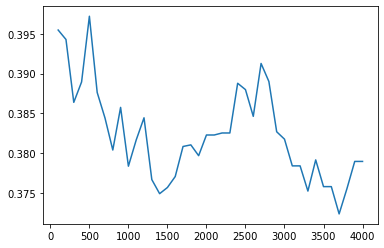

In [31]:
import matplotlib.pyplot as plt
plt.plot(*zip(*result))

In [32]:
max(result,key=lambda item:item[1])

(500, 0.39721189845223953)